# CYPLAN255
### Urban Informatics and Visualization

# Lecture 09 -- Data Analysis
*******
February 14, 2024

<img src="https://upload.wikimedia.org/wikipedia/commons/7/70/Eug%C3%A8ne_Delacroix_-_The_Barque_of_Dante.jpg" width=80% title="The Barque of Dante, Eugène Delacroix (1822)">


# Agenda
1. Announcements
2. Review of last session
3. Data Analysis
4. For next time
5. Questions


# 1. Announcements

1. Assignment 2 due Monday
2. Assignment 1 will be graded soon

# 2. Review from Intro to Data Analysis

## 2.1 Indexing and Selecting

- use `[<row>, <column>]` indexing with `loc` (labels) and `iloc` (positions)
- use `df[<col>]` to select a column/Series from a DataFrame by column label
- use `df[[<col1>, <col2>]]` to select a subset of a DataFrame by column label

## 2.2 Merge Methods

Most of the below is taken directly from the pandas [docs](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html#brief-primer-on-merge-methods-relational-algebra).

There are 4 main types of merges, but all of them require **four** arguments:
- `left`: first `DataFrame` or `Series` to merge
- `right`: second `DataFrame` or `Series` to merge with the first 
- `on`: the name of the "key" column(s) you'll use to identify matching/corresponding rows in each table
- `how`: the type of merge to perform (default is "inner")

Let's see how this works in practice. First we'll create some data:

In [ ]:
import pandas as pd

left = pd.DataFrame(

    {
        "key1": ["K0", "K0", "K1", "K2"],
        "key2": ["K0", "K1", "K0", "K1"],
        "A": ["A0", "A1", "A2", "A3"],
        "B": ["B0", "B1", "B2", "B3"],
    }

)

right = pd.DataFrame(
    {
        "key1": ["K0", "K1", "K1", "K2"],
        "key2": ["K0", "K0", "K0", "K0"],
        "C": ["C0", "C1", "C2", "C3"],
        "D": ["D0", "D1", "D2", "D3"],
    }
)

And now we'll do some merges

**inner** join
![](https://pandas.pydata.org/pandas-docs/stable/_images/merging_merge_on_key_multiple.png)

In [ ]:
pd.merge(left, right, on=["key1", "key2"])  # inner is default "how", so we don't need to specify it

**left** join
![](https://pandas.pydata.org/pandas-docs/stable/_images/merging_merge_on_key_left.png)

In [ ]:
pd.merge(left, right, how="left", on=["key1", "key2"])

**right** join
![](https://pandas.pydata.org/pandas-docs/stable/_images/merging_merge_on_key_right.png)

In [ ]:
pd.merge(right, left, how="left", on=["key1", "key2"])

**outer** (A.K.A. full) join
![](https://pandas.pydata.org/pandas-docs/stable/_images/merging_merge_on_key_outer.png)

In [ ]:
pd.merge(left, right, how="outer", on=["key1", "key2"])

**cross** join (A.K.A. Cartesian Product)
![](https://pandas.pydata.org/pandas-docs/stable/_images/merging_merge_cross.png)

In [ ]:
pd.merge(left, right, how="cross").head()

## 2.3 Handling duplicate column names

In [ ]:
left = pd.DataFrame({"A": [4, 5], "B": [2, 2], "C": [5, 7]})
right = pd.DataFrame({"A": [4, 5, 6], "B": [2, 2, 2], "D": [9, 8, 1]})
pd.merge(left, right, on=["B"], how="inner")

### 2.3.1 Define your own suffixes!

**Keep all columns, but give them meaningful names**

In [ ]:
pd.merge(left, right, on="B", how="inner", suffixes=('_left', '_right'))

**Use suffixes to drop duplicate columns after merge**

In [ ]:
result = pd.merge(left, right, on="B", how="inner", suffixes=('_trash', ''))

In [ ]:
result

In [ ]:
result[['B','C']]

In [ ]:
# keep only cols you want
good_cols = [col for col in result.columns if not 'trash' in col]
result[good_cols]

In [ ]:
# drop cols you don't want
trash_cols = [col for col in result.columns if 'trash' in col]
result.drop(trash_cols, axis=1)  # "axis" tells pandas to drop columns (axis=1) or rows (axis=2)

### 2.3.2 Filter out duplicate columns before you merge!

In [ ]:
key = "B"
left_col_mask = [col for col in left.columns if (col not in right.columns) or (col == key)]
pd.merge(left[left_col_mask], right, on=key, how="inner")

# 3. Exploratory Data Analysis with pandas

**READ THE DOCS**

Most of the pandas-related material we saw **yesterday** corresponds to three sections of the pandas user guide:
1. [Basics](https://pandas.pydata.org/pandas-docs/stable/user_guide/basics.html)
2. [Indexing and Selecting](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html)
3. [Merge, join, concatenate, and compare](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html)


Most of the material we're covering **today** is also covered in the following three sections of the pandas user guide:
1. [Group by: split-apply-combine](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html)
2. [Reshaping and pivot tables](https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html)
3. [Chart visualization](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html)

**Everything** we're covering in pandas is summarized nicely in the [10 minutes to pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html) section.

## 3.1 The `groupby()` method

For the first part of this lesson, we're going to be analyzing some Bay Area Census data which I've already grabbed for you (specifically the Summary File 1 (SF1) data from the 2010 Census). Refer to the [SF1 Data Dictionary](https://www.census.gov/prod/cen2010/doc/sf1.pdf) to see the list of column codes. I've compiled this data into an HDF5 file, which is kind of like a .zip archive that lets you unzip one file at a time.

In [ ]:
sf1 = pd.read_hdf('data/bay_sf1_small.h5', 'sf1_extract')
sf1.head()

**Note on HDF5 dependencies**

pandas uses the `pytables` library to interact with .h5 files. If you don't have it installed and you try to run the cell above, Python may complain. Fear not. Did you know you can execute bash terminal commands directly from a notebook?

In [ ]:
# !conda install pytables

### 3.1.1 Basic Data Transformations

In the world of machine learning, data transformation is sometimes called **feature extraction**. Both terms refer to the process of taking "raw" input data and manipulating it to create new, useful data. In the example below, we convert population totals to percentages:

In [ ]:
sf1['pct_black'] = sf1['P0030003'] / sf1['P0030001'] * 100
sf1['pct_asian'] = sf1['P0030005'] / sf1['P0030001'] * 100
sf1['pct_white'] = sf1['P0030002'] / sf1['P0030001'] * 100
sf1['pct_hisp'] = sf1['P0040003'] / sf1['P0040001'] * 100
sf1

Now add colums with percentage rental and population per square mile.

In [ ]:
sf1['pct_rent'] = sf1['H0040004'] / sf1['H0040001'] * 100
sf1['pop_sqmi'] = (sf1['P0010001'] / (sf1['arealand'] / 2589988))
sf1 = sf1[sf1['P0030001'] > 0]
sf1.sample(3)

Notice how when we create new columns they get automatically appended to the end (right) of the table

Now let's add county names to the dataframe so we get more readable output. First we'll create a dictionary to map the FIPS codes to county names

In [ ]:
county_fips_to_name = {
    '001': 'Alameda', '013': 'Contra Costa', '041': 'Marin', '055': 'Napa', '075': 'San Francisco',
    '081': 'San Mateo', '085': 'Santa Clara', '095': 'Solano', '097': 'Sonoma'}

Then we pass that dictionary to the `pd.Series.replace()` method to perform the conversion.

We could use the same assignment-based approach to create our new column:

In [ ]:
sf1['county_name'] = sf1['county'].replace(county_fips_to_name)

or we can use `pd.DataFrame.insert()` to tell pandas exactly where to stick the new column

In [ ]:
a = 5
a + 10

In [ ]:
del sf1['county_name']  # drop the column we just created
sf1.insert(4, 'county_name', sf1['county'].replace(county_fips_to_name))
sf1.head(3)

Notice how `insert()` operates "in-place"?

### 3.1.2 Split-Apply-Combine

Groupby is a powerful method in pandas that follows the split-apply-combine approach to data manipulation.

<center><img src="https://wesmckinney.com/book/images/pda3_1001.png" width=40%></center>

**SPLIT**

Let's apply this approach to computing total population in each county in our dataset. First we create a groupby object, using county codes to group all the census blocks in sf1 into groups that share the same county code. This represents the **split** part of the workflow in the figure above

In [ ]:
sf1[['P0010001', 'county_name']].groupby('county_name').sum()

**APPLY**

Now were ready to apply an operation to each group we've split. We call these **aggregation** methods because for each group they will take a series of values and combine them to produce one value, like a min/max/mean. pandas provides a bunch of built-in aggregation functions for use with `groupby` object. Some of the most common ones include:

* `count`
* `sum`
* `mean`
* `median`
* `std`, `var`
* `min`, `max`
* `idxmax`, `idxmin`
* `first`, `last`
* `quantile`

But you can also define and apply your own functions to use for aggregation.

**COMBINE**

To apply your chosen aggregation, you can call it directly as a method of your `groupby` object. The object pandas returns will be the **combined** outputs of this method for each of your groups:

In [ ]:
grouped.sum()

**SPLIT-APPLY-COMBINE**

Doing this in two steps like above is really just to clarify the two parts of the split and apply process that happen within a groupy operation. Normally we would not bother separately creating a groupby object -- we would just do this in one line:

In [ ]:
county_pop = sf1[['county_name', 'P0010001']].rename(columns={'P0010001': 'total_pop'}).groupby('county_name').sum()
county_pop

## 3.2 Aggregating on multiple columns

Let's merge the county totals with the original sf1 data

In [ ]:
county_pop.reset_index(inplace=True)
county_pop

In [ ]:
sf2 = pd.merge(sf1, county_pop, on='county_name', how='inner')
sf2.head()

Let's say we wanted to compute the population per square mile by county.  We could go ahead and create another dataframe with total area by county than then divide the total population by total area.

In [ ]:
county_land = sf1[['county_name', 'arealand']].groupby(sf1['county_name']).sum()
county_land

In [ ]:
county_pop['total_pop'].values

In [ ]:
sq_m_to_sq_mi = 2589988.11 
county_pop['total_pop'].values / county_land['arealand'].values * sq_m_to_sq_mi

Or, we could have done both aggregations at the same time!

In [ ]:
county_totals = sf1[['county_name', 'P0010001', 'arealand']].groupby('county_name').sum()
county_totals['pop_density'] = county_totals['P0010001'] / county_totals['arealand'] * sq_m_to_sq_mi
county_totals

What if we want to apply different aggregations to different columns? 

In [ ]:
sf1.groupby('county_name').agg({'pct_asian': 'mean', 'P0010001': 'sum'})

### Question 1

Sometimes I write `df[<list of columns>].groupby()`, but sometimes I just do `df.groupby()`. Why?

## 3.3 Exercises:

Count the number of census blocks per county.

Calculate total households per county.

Calculate percent renters by county. (Careful not to calculate the mean percent rental across blocks in a county)

Calculate percent vacant by county.

Calculate mean, min and max pop_sqmi (at the block level) by county.

Calculate the 90th percentile of pop_sqmi (at the block level) by county.

In [ ]:
print('Number of census blocks per county:')

In [ ]:
print('Total households per county')

In [ ]:
print('percent renters by county')

In [ ]:
print('Percent vacant by county')

In [ ]:
print('Min, Max and Mean Population per SQMI by Census Block')

In [ ]:
print('90th Percentile of Population per SQMI at block level by County')

## 3.4 Cleaning Messy Data -- Craigslist Rental Listings

### 3.4.1 Loading data
Let's load some rental listings I scraped from Craigslist.  

In [54]:
import pandas as pd
df = pd.read_csv('data/bay.csv')
df.head()

,neighborhood,title,price,beds_sqft,pid,longitude,date,subregion,link,latitude
0,(bayview),Take A TOUR ON OUR ONE FURNISHED BEDROOM TODAY,$950,/ 1br -,4076905111,-122.396965,Sep 18 2013,SF,/sfc/apa/4076905111.html,37.761216
1,(bayview),Only walking distance to major shopping centers.,$950,/ 1br -,4076901755,-122.396793,Sep 18 2013,SF,/sfc/apa/4076901755.html,37.761080
2,(bayview),"furnished - 1 Bedroom(s), 1 Bath(s), Air Condi...",$950,/ 1br -,4076899340,-122.397100,Sep 18 2013,SF,/sfc/apa/4076899340.html,37.762100
3,(financial district),"*NEW* Beautiful, Upscale Condo in Historic Jac...",$3300,/ 1br - 830ft² -,4067393707,-122.399747,Sep 18 2013,SF,/sfc/apa/4067393707.html,37.798108
4,(visitacion valley),楼上全层3房,$2000,/ 3br - 1280ft² -,4076901071,NaN,Sep 18 2013,SF,/sfc/apa/4076901071.html,NaN


It turns out to be pretty messy. What problems do you see?


- Neighborhood names are in parentheses...
- Bedrooms and Square Feet are embedded in a single string in the bedrooms column along with other text...
- Price is formatted as a string with a dollar sign...
- Date is a string in a non-standard format...

So how can we go about cleaning these data up to use them for analysis?

Let's start with cleaning up the Price and Neighborhood variables.

### 3.4.2 String Ops

In [55]:
df.head()

,neighborhood,title,price,beds_sqft,pid,longitude,date,subregion,link,latitude
0,(bayview),Take A TOUR ON OUR ONE FURNISHED BEDROOM TODAY,$950,/ 1br -,4076905111,-122.396965,Sep 18 2013,SF,/sfc/apa/4076905111.html,37.761216
1,(bayview),Only walking distance to major shopping centers.,$950,/ 1br -,4076901755,-122.396793,Sep 18 2013,SF,/sfc/apa/4076901755.html,37.761080
2,(bayview),"furnished - 1 Bedroom(s), 1 Bath(s), Air Condi...",$950,/ 1br -,4076899340,-122.397100,Sep 18 2013,SF,/sfc/apa/4076899340.html,37.762100
3,(financial district),"*NEW* Beautiful, Upscale Condo in Historic Jac...",$3300,/ 1br - 830ft² -,4067393707,-122.399747,Sep 18 2013,SF,/sfc/apa/4067393707.html,37.798108
4,(visitacion valley),楼上全层3房,$2000,/ 3br - 1280ft² -,4076901071,NaN,Sep 18 2013,SF,/sfc/apa/4076901071.html,NaN


In [56]:
df['price'] = df['price'].str.strip('$').astype('float64')
df['neighborhood'] = df['neighborhood'].str.strip().str.strip('(').str.strip(')')
df.head()

,neighborhood,title,price,beds_sqft,pid,longitude,date,subregion,link,latitude
0,bayview,Take A TOUR ON OUR ONE FURNISHED BEDROOM TODAY,950.0,/ 1br -,4076905111,-122.396965,Sep 18 2013,SF,/sfc/apa/4076905111.html,37.761216
1,bayview,Only walking distance to major shopping centers.,950.0,/ 1br -,4076901755,-122.396793,Sep 18 2013,SF,/sfc/apa/4076901755.html,37.761080
2,bayview,"furnished - 1 Bedroom(s), 1 Bath(s), Air Condi...",950.0,/ 1br -,4076899340,-122.397100,Sep 18 2013,SF,/sfc/apa/4076899340.html,37.762100
3,financial district,"*NEW* Beautiful, Upscale Condo in Historic Jac...",3300.0,/ 1br - 830ft² -,4067393707,-122.399747,Sep 18 2013,SF,/sfc/apa/4067393707.html,37.798108
4,visitacion valley,楼上全层3房,2000.0,/ 3br - 1280ft² -,4076901071,NaN,Sep 18 2013,SF,/sfc/apa/4076901071.html,NaN


OK, now lets create Year, Month and Day columns

In [57]:
df['month'] = df['date'].str.split().str[0]
df['day'] = df['date'].str.split().str[1].astype('int32')
df['year'] = df['date'].str.split().str[2].astype('int32')
df.head()

,neighborhood,title,price,beds_sqft,pid,longitude,date,subregion,link,latitude,month,day,year
0,bayview,Take A TOUR ON OUR ONE FURNISHED BEDROOM TODAY,950.0,/ 1br -,4076905111,-122.396965,Sep 18 2013,SF,/sfc/apa/4076905111.html,37.761216,Sep,18,2013
1,bayview,Only walking distance to major shopping centers.,950.0,/ 1br -,4076901755,-122.396793,Sep 18 2013,SF,/sfc/apa/4076901755.html,37.761080,Sep,18,2013
2,bayview,"furnished - 1 Bedroom(s), 1 Bath(s), Air Condi...",950.0,/ 1br -,4076899340,-122.397100,Sep 18 2013,SF,/sfc/apa/4076899340.html,37.762100,Sep,18,2013
3,financial district,"*NEW* Beautiful, Upscale Condo in Historic Jac...",3300.0,/ 1br - 830ft² -,4067393707,-122.399747,Sep 18 2013,SF,/sfc/apa/4067393707.html,37.798108,Sep,18,2013
4,visitacion valley,楼上全层3房,2000.0,/ 3br - 1280ft² -,4076901071,NaN,Sep 18 2013,SF,/sfc/apa/4076901071.html,NaN,Sep,18,2013


### 3.4.3 Datetime ops

pandas has special functions for dealing with `datetime` data types which make it much easier to do what we just did above. First we have to convert our date-like column to a `datetime` column

In [59]:
df['date'] = pd.to_datetime(df['date'])

Now we can use the `dt` method (just like `.str.` for string ops) to get month, day, year, and whatever else we want:

In [63]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month_name()
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.day_name()

In [64]:
df[['date', 'day', 'month', 'year', 'day_of_week']].head()

,date,day,month,year,day_of_week
0,2013-09-18,18,September,2013,Wednesday
1,2013-09-18,18,September,2013,Wednesday
2,2013-09-18,18,September,2013,Wednesday
3,2013-09-18,18,September,2013,Wednesday
4,2013-09-18,18,September,2013,Wednesday


### 3.4.4 Complex string processing

Let's see how we might extract the bedrooms...

In [66]:
df.beds_sqft.sample(5)

401                  / 1br -    
1375                 / 1br -    
1080                 / 2br -    
1586       / 3br - 1700ft² -    
4322        / 1br - 600ft² -    
Name: beds_sqft, dtype: object

In [75]:
df.head()

,neighborhood,title,price,beds_sqft,pid,longitude,date,subregion,link,latitude,month,day,year,day_of_week
0,bayview,Take A TOUR ON OUR ONE FURNISHED BEDROOM TODAY,950.0,/ 1br -,4076905111,-122.396965,2013-09-18,SF,/sfc/apa/4076905111.html,37.761216,September,18,2013,Wednesday
1,bayview,Only walking distance to major shopping centers.,950.0,/ 1br -,4076901755,-122.396793,2013-09-18,SF,/sfc/apa/4076901755.html,37.761080,September,18,2013,Wednesday
2,bayview,"furnished - 1 Bedroom(s), 1 Bath(s), Air Condi...",950.0,/ 1br -,4076899340,-122.397100,2013-09-18,SF,/sfc/apa/4076899340.html,37.762100,September,18,2013,Wednesday
3,financial district,"*NEW* Beautiful, Upscale Condo in Historic Jac...",3300.0,/ 1br - 830ft² -,4067393707,-122.399747,2013-09-18,SF,/sfc/apa/4067393707.html,37.798108,September,18,2013,Wednesday
4,visitacion valley,楼上全层3房,2000.0,/ 3br - 1280ft² -,4076901071,NaN,2013-09-18,SF,/sfc/apa/4076901071.html,NaN,September,18,2013,Wednesday


In [76]:
def clean_bdrm(value):

    if isinstance(value, str):
        end = value.find('br')

        if end == -1:
            return
        
        else:
            start = value.find('/') + 2
            return int(value[start:end])

    else:
        return

df['bedrooms'] = df['beds_sqft'].map(clean_bdrm)

And the same approach might work for creating a sqft column.

In [81]:
df.head()

,neighborhood,title,price,beds_sqft,pid,longitude,date,subregion,link,latitude,month,day,year,day_of_week,bedrooms
0,bayview,Take A TOUR ON OUR ONE FURNISHED BEDROOM TODAY,950.0,/ 1br -,4076905111,-122.396965,2013-09-18,SF,/sfc/apa/4076905111.html,37.761216,September,18,2013,Wednesday,1.0
1,bayview,Only walking distance to major shopping centers.,950.0,/ 1br -,4076901755,-122.396793,2013-09-18,SF,/sfc/apa/4076901755.html,37.761080,September,18,2013,Wednesday,1.0
2,bayview,"furnished - 1 Bedroom(s), 1 Bath(s), Air Condi...",950.0,/ 1br -,4076899340,-122.397100,2013-09-18,SF,/sfc/apa/4076899340.html,37.762100,September,18,2013,Wednesday,1.0
3,financial district,"*NEW* Beautiful, Upscale Condo in Historic Jac...",3300.0,/ 1br - 830ft² -,4067393707,-122.399747,2013-09-18,SF,/sfc/apa/4067393707.html,37.798108,September,18,2013,Wednesday,1.0
4,visitacion valley,楼上全层3房,2000.0,/ 3br - 1280ft² -,4076901071,NaN,2013-09-18,SF,/sfc/apa/4076901071.html,NaN,September,18,2013,Wednesday,3.0


In [82]:
def clean_sqft(value):

    if isinstance(value, str):
        end = value.find('ft')
        
        if end == -1:
            return

        else:
            if value.find('br') == -1:
                start = value.find('/') + 2
            else:
                start = value.find('-') + 2

            return int(value[start:end])

    else:
        return

In [83]:
df['sqft'] = df['beds_sqft'].map(clean_sqft)
df.head()

,neighborhood,title,price,beds_sqft,pid,longitude,date,subregion,link,latitude,month,day,year,day_of_week,bedrooms,sqft
0,bayview,Take A TOUR ON OUR ONE FURNISHED BEDROOM TODAY,950.0,/ 1br -,4076905111,-122.396965,2013-09-18,SF,/sfc/apa/4076905111.html,37.761216,September,18,2013,Wednesday,1.0,NaN
1,bayview,Only walking distance to major shopping centers.,950.0,/ 1br -,4076901755,-122.396793,2013-09-18,SF,/sfc/apa/4076901755.html,37.761080,September,18,2013,Wednesday,1.0,NaN
2,bayview,"furnished - 1 Bedroom(s), 1 Bath(s), Air Condi...",950.0,/ 1br -,4076899340,-122.397100,2013-09-18,SF,/sfc/apa/4076899340.html,37.762100,September,18,2013,Wednesday,1.0,NaN
3,financial district,"*NEW* Beautiful, Upscale Condo in Historic Jac...",3300.0,/ 1br - 830ft² -,4067393707,-122.399747,2013-09-18,SF,/sfc/apa/4067393707.html,37.798108,September,18,2013,Wednesday,1.0,830.0
4,visitacion valley,楼上全层3房,2000.0,/ 3br - 1280ft² -,4076901071,NaN,2013-09-18,SF,/sfc/apa/4076901071.html,NaN,September,18,2013,Wednesday,3.0,1280.0


## 3.5 Summarizing your data

Let's have a look at a statistical profile of our data

In [84]:
df.describe()

,price,pid,longitude,latitude,day,year,bedrooms,sqft
count,4908.000000,5.000000e+03,3143.000000,3143.000000,5000.000000,5000.0,4544.000000,3178.000000
mean,2656.999389,4.068059e+09,-122.264948,37.757411,17.523800,2013.0,2.066241,1173.613593
std,1915.147477,1.344453e+07,0.278825,0.364646,0.766258,0.0,1.011606,751.552623
min,1.000000,4.008227e+09,-123.799100,36.813820,14.000000,2013.0,1.000000,1.000000
25%,1695.000000,4.065685e+09,-122.442365,37.469365,17.000000,2013.0,1.000000,747.250000
50%,2208.500000,4.074290e+09,-122.283714,37.760858,18.000000,2013.0,2.000000,1000.000000
75%,2995.000000,4.075949e+09,-122.045048,37.900832,18.000000,2013.0,3.000000,1350.000000
max,35000.000000,4.076908e+09,-120.034132,41.456848,18.000000,2013.0,8.000000,12700.000000


- Why are there different counts on the columns?
- How do the price (rent) variable ranges look?  1 dollar in rent as min?  35,000 in rent as  maximum?
- What about sqft?  1 sqft min and 12,700 sqft max?
- You are now in the realm of real-world data, with **outliers**!

## 3.6 Dealing with outliers
When we talk about **outliers**, we're not talking about the Malcom Gladwell kind. The kind of outliers we're talking about are the kind that are so far-fetched that they more likely represent bad data than real observations. And even if they are real, they're so amazingly rare that we don't want them to bias our analysis. In either case, we need to get rid of them.

In the case of our Craigslist listings, we'll do this in three steps:
1. Find outliers in rent, say the top and bottom 1%
1. Analyze the data without missing data
1. Create a dataset that removes the outliers

### 3.6.1 Price

Let's get a quantile value at the 1st percentile to see the value that the top one percent of our records exceed

In [85]:
low = df['price'].dropna().quantile(.01)
print(low)

750.0


And now the top 1%

In [86]:
high = df['price'].dropna().quantile(.99)
print(high)

10472.000000000116


<center><img src="https://static01.nyt.com/images/2021/01/26/multimedia/26xp-photog/26xp-photog-superJumbo.jpg" width=70%></center>

Now let's apply our filters:

In [90]:
cleaned = df[(df['price'] < high) & (df['price'] > low)].copy()

And maybe we can filter on # bedrooms, too. And why not drop rows with missing data while we're at it.

In [91]:
cleaned = cleaned[cleaned['bedrooms'] < 4].dropna()
cleaned.describe()

,price,pid,longitude,latitude,day,year,bedrooms,sqft
count,1731.000000,1.731000e+03,1731.000000,1731.000000,1731.000000,1731.0,1731.000000,1731.000000
mean,2487.301560,4.068727e+09,-122.232862,37.720729,17.545350,2013.0,1.870017,1050.700173
std,1139.013985,1.285543e+07,0.271460,0.372940,0.733662,0.0,0.735458,425.224452
min,751.000000,4.012055e+09,-123.799100,36.847162,14.000000,2013.0,1.000000,200.000000
25%,1775.000000,4.067026e+09,-122.432681,37.414654,17.000000,2013.0,1.000000,758.000000
50%,2250.000000,4.074468e+09,-122.250000,37.656165,18.000000,2013.0,2.000000,976.000000
75%,2897.000000,4.076009e+09,-122.014171,37.894828,18.000000,2013.0,2.000000,1200.000000
max,9999.000000,4.076900e+09,-121.217798,40.086400,18.000000,2013.0,3.000000,6500.000000


## 3.7 Continuous vs Categorical Data

<AxesSubplot:title={'center':'Price ($)'}, ylabel='Density'>

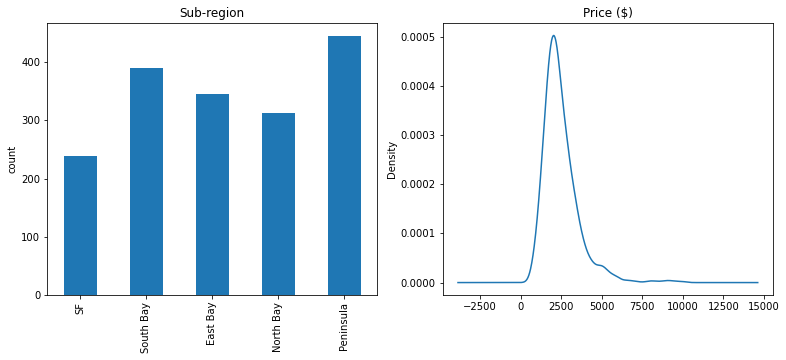

In [92]:
from matplotlib import pyplot as plt
fig, axarr = plt.subplots(1, 2, figsize=(13,5))
cleaned['subregion'].value_counts(sort=False).plot(kind='bar', ax=axarr[0], title='Sub-region')
axarr[0].set_ylabel("count")
cleaned['price'].plot(kind='kde', ax=axarr[1], title='Price ($)')

### 3.7.1 Binning your data
Sometimes you'll want to convert a continuous variable to categorical. pandas provides us with a few options for doing this:
- `pd.cut()`: evenly _spaced_ bins, or define your own breaks
- `pd.qcut()`: evenly _populated_ bins, or define your own percentile breaks

#### 3.7.1.1 `pd.cut()`

<AxesSubplot:>

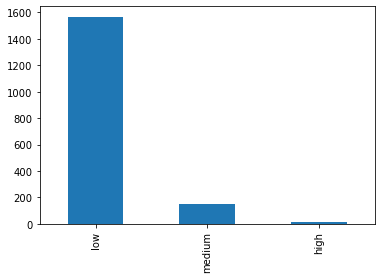

In [96]:
pd.cut(cleaned['price'], 3, labels=['low', 'medium', 'high']).value_counts().plot(kind='bar')

<AxesSubplot:>

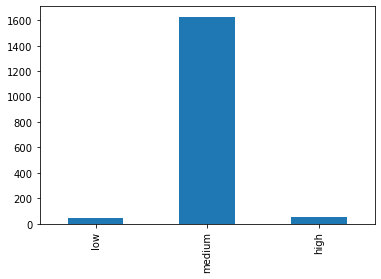

In [97]:
pd.cut(
    cleaned['price'], [0, 1000, 5000, 20000],
    labels=['low', 'medium', 'high']).value_counts(sort=False).plot(kind='bar')

#### 3.7.1.2 `pd.qcut()`

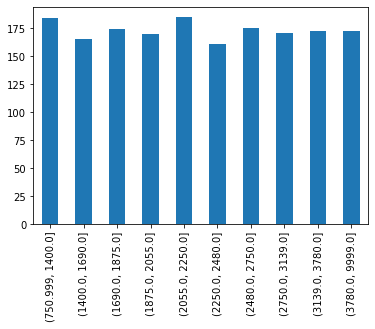

In [102]:
quintile_df = pd.qcut(
    cleaned['price'], 10,
#     labels=['very low', 'low', 'average', 'high', 'very high']
).value_counts(sort=False).plot(kind='bar')

<AxesSubplot:>

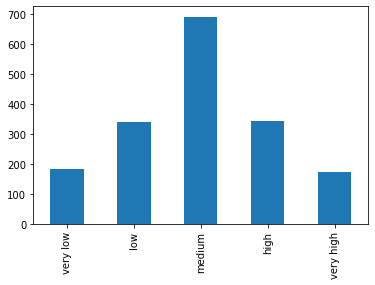

In [105]:
pd.qcut(
    cleaned['price'], [0, .1, .3, .7, .9, 1],
    labels=['very low', 'low', 'medium', 'high', 'very high']).value_counts(
    sort=False
).plot(kind='bar')

### 3.7.2 Dummy variables

Sometimes you might want to do the opposite: convert a categorical variable to a continuous or numeric variable. The way to do this is to create "dummy variables", where each category becomes its own _column_ with values that equal 1 if the _row_ belongs to the category and 0 otherwise:

In [108]:
pd.get_dummies(cleaned['subregion'],dtype=int)

,East Bay,North Bay,Peninsula,SF,South Bay
3,0,0,0,1,0
10,0,0,0,1,0
11,0,0,0,1,0
12,0,0,0,1,0
13,0,0,0,1,0
...,...,...,...,...,...
4992,0,0,1,0,0
4994,0,0,1,0,0
4996,0,0,1,0,0
4998,0,0,1,0,0


You can then merge your dummy columns back onto the main dataframe

In [109]:
cleaned.join(pd.get_dummies(cleaned['bedrooms'].astype(int), prefix='beds')).loc[:, 'bedrooms':].sample(5)

,bedrooms,sqft,beds_1,beds_2,beds_3
4623,2.0,955.0,0,1,0
3832,2.0,1080.0,0,1,0
2960,2.0,850.0,0,1,0
3275,1.0,800.0,1,0,0
1588,2.0,985.0,0,1,0


## 3.8 Putting it all together: Craigslist Rental Listings + SF1

Let's load another set of rental listings. This one is a dataset I've already cleaned for you. I've also geocoded the addresses to get lat/lon coordinates and Census Block IDs.

### 3.8.1 Merging data from two different sources

In [110]:
rentals = pd.read_csv(
    'data/sfbay_geocoded.csv',
    usecols=['rent', 'bedrooms', 'sqft', 'fips_block', 'longitude', 'latitude'],
    dtype={'fips_block': str}  # load fips_block as str, numeric type will drop leading zero
)  
rentals.head()

,rent,bedrooms,sqft,longitude,latitude,fips_block
0,4500.0,2.0,1200.0,-122.438300,37.745000,060750216002015
1,2650.0,2.0,1040.0,-122.008131,37.353699,060855085053008
2,3100.0,2.0,1000.0,-122.439743,37.731584,060750311005011
3,1850.0,1.0,792.0,-122.234294,37.491715,060816101001026
4,1325.0,1.0,642.0,-122.087751,37.923448,060133400021004


And merge it with the census data using the FIPS block codes, which are named differently in the two DataFrames.

In [111]:
county_fips_to_name = {
    '001': 'Alameda', '013': 'Contra Costa', '041': 'Marin', '055': 'Napa', '075': 'San Francisco',
    '081': 'San Mateo', '085': 'Santa Clara', '095': 'Solano', '097': 'Sonoma'}
sf1 = pd.read_hdf('data/bay_sf1_small.h5', 'sf1_extract')
sf1['county_name'] = sf1['county'].replace(county_fips_to_name)

In [113]:
rentals_sf1 = pd.merge(rentals, sf1, left_on='fips_block', right_on='blockfips')
rentals_sf1.head()

,rent,bedrooms,sqft,longitude,latitude,fips_block,logrecno,blockfips,state,county,...,H0040004,H0050001,H0050002,H0050003,H0050004,H0050005,H0050006,H0050007,H0050008,county_name
0,4500.0,2.0,1200.0,-122.438300,37.745000,060750216002015,589261,060750216002015,06,075,...,256,18,7,0,3,0,3,0,5,San Francisco
1,6250.0,3.0,1215.0,-122.438300,37.745000,060750216002015,589261,060750216002015,06,075,...,256,18,7,0,3,0,3,0,5,San Francisco
2,6250.0,3.0,1215.0,-122.438300,37.745000,060750216002015,589261,060750216002015,06,075,...,256,18,7,0,3,0,3,0,5,San Francisco
3,6650.0,3.0,2900.0,-122.440088,37.745296,060750216002015,589261,060750216002015,06,075,...,256,18,7,0,3,0,3,0,5,San Francisco
4,2600.0,1.0,615.0,-122.440088,37.745296,060750216002015,589261,060750216002015,06,075,...,256,18,7,0,3,0,3,0,5,San Francisco


### 3.8.2 Multi-column group-by's

Now we can begin looking at this merged dataset.  Let's start by computing mean rents by county.

<AxesSubplot:xlabel='county_name'>

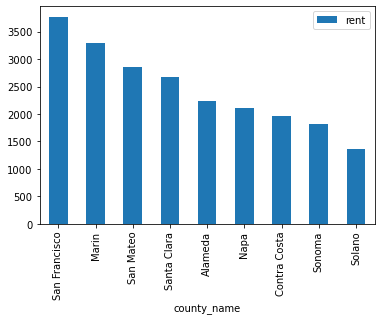

In [114]:
county_rents = rentals_sf1.groupby(
    rentals_sf1['county_name'])[['rent']].mean().sort_values(by='rent', ascending=False)
county_rents.plot(kind='bar')

This result generally conforms to our expectations, with San Francisco having the highest average rent and Solano lowest. But what if Solano just has a higher percentage of 1 bedroom apartments? Could that bias our findings? How might we account for this possibility?

One way we could investigate the effect of total bedrooms is to include bedrooms as an additional segmentation variable:

<AxesSubplot:xlabel='county_name,bedrooms'>

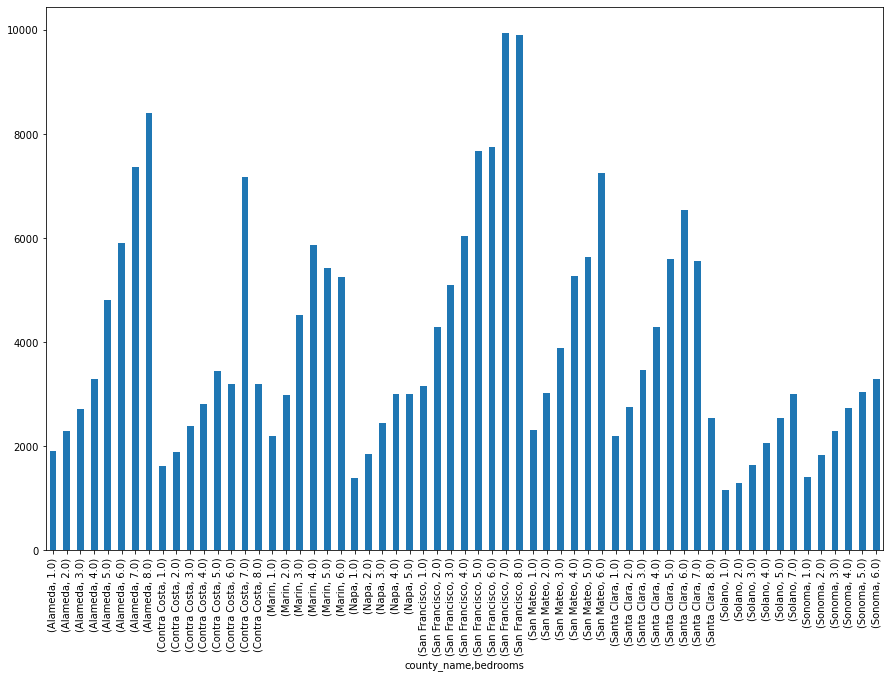

In [117]:
fig, ax = plt.subplots(figsize=(15,10))
rentals_sf1.groupby(['county_name', 'bedrooms'])['rent'].mean().plot(kind='bar', ax=ax)

That bar chart is not ideal. Too small, and it would be nicer to make it separate colors for each number of bedrooms.  Also notice how the use of two groupby variables produces a MultiIndex, which makes for ugly axis labels at the very least. 

We can use `unstack()` to convert one of the indices from row values to columns:

In [120]:
rentals_sf1.groupby(['county_name', 'bedrooms'])['rent'].mean().unstack()

bedrooms,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0
county_name,,,,,,,,
Alameda,1906.363408,2294.724966,2712.036364,3292.393145,4809.365741,5898.392857,7362.500000,8400.0
Contra Costa,1623.475236,1884.487562,2383.374771,2811.954866,3452.313725,3190.625000,7172.500000,3200.0
Marin,2204.514731,2988.890511,4516.865979,5871.608939,5417.812500,5250.000000,NaN,NaN
Napa,1387.365385,1842.866667,2446.071429,2998.593750,3009.000000,NaN,NaN,NaN
San Francisco,3149.643165,4293.614982,5101.344828,6033.762557,7665.400000,7750.000000,9950.000000,9900.0
San Mateo,2307.106793,3014.384848,3890.428715,5274.883721,5644.625000,7260.000000,NaN,NaN
Santa Clara,2187.097311,2759.360487,3473.309386,4282.827345,5590.742857,6541.666667,5566.666667,2550.0
Solano,1155.899787,1284.035185,1640.721414,2053.763547,2534.814815,NaN,3000.000000,NaN
Sonoma,1412.111635,1838.657343,2299.699387,2738.465347,3037.500000,3295.000000,NaN,NaN


Now we can plot a bar chart with the unstacked data, add a title, and set the figure size.

<AxesSubplot:title={'center':'Average Rents by County and # Bedrooms'}, xlabel='county', ylabel='rent ($)'>

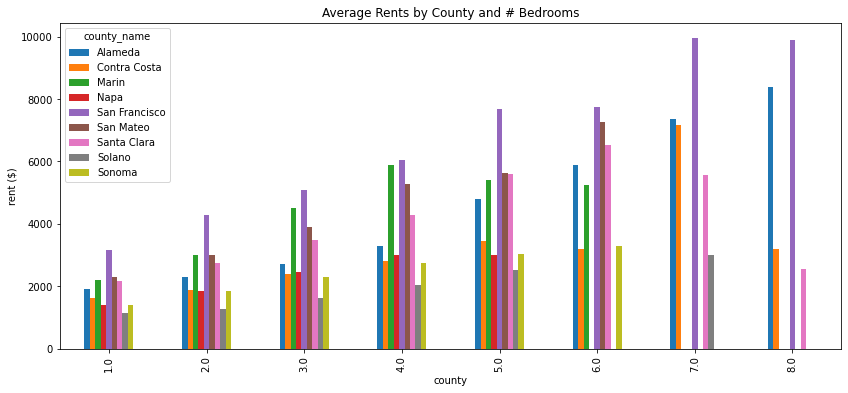

In [125]:
rentals_sf1.groupby(['bedrooms', 'county_name'])['rent'].mean().unstack(level=1).plot(kind='bar', figsize=(14,6), title='Average Rents by County and # Bedrooms', ylabel='rent ($)', xlabel='county')

Note that in one line of code we can filter, groupby, and plot our results.

**Question:** What's wrong with the plot above? Is it really showing us what we're interested in?

What if we want to look at more statistics than just mean? We can combine several aggregation methods and compute them at one time:

In [ ]:
rentals_sf1[rentals_sf1['bedrooms'] < 4].groupby(
    ['county_name', 'bedrooms'])['rent'].agg(['mean', 'std', 'min', 'max']).reset_index().head()

### 3.8.3 Pivot tables and Crosstabs

Remember when I said that in programming there is always more than one way to skin a cat? Here is another way of skinning this one that should look familiar to all of you excel power users out there:

In [ ]:
pd.pivot_table(rentals_sf1, values='rent', index=['bedrooms'], columns=['county_name']).plot(
    kind='bar', figsize=(14,6), title='Average Rents by County and Bedrooms')

The `pivot_table()` function makes it easy to add also can add partial totals, or "marginals", to our data:

In [ ]:
pd.pivot_table(rentals_sf1, values='rent', index='county_name', columns='bedrooms', margins=True)

Although mean is the default type of aggregation in pivot_table, you can use any aggregation method:

In [ ]:
pd.pivot_table(
    rentals_sf1, values='rent', index='county_name', columns='bedrooms', aggfunc="median", margins=True)

We could use the `count` aggregation method to get a full frequency distribution, a.k.a cross-tabulation

But then again, there's an even simpler way to do this in pandas

In [ ]:
pd.crosstab(rentals_sf1['county_name'], rentals_sf1['bedrooms'], margins=True)

And the `crosstab()` function comes with its own bells and whistles. For example, setting `normalize=True` will tells us the fraction of the region's total listings that are in each combination of county and number of bedrooms.

In [ ]:
pd.crosstab(rentals_sf1['county_name'], rentals_sf1['bedrooms'], margins=True, normalize=True)

We could also normalize just the rows (index) or the just the columns:

In [ ]:
pd.crosstab(rentals_sf1['county_name'], rentals_sf1['bedrooms'], margins=True, normalize='index')

In [ ]:
pd.crosstab(rentals_sf1['county_name'], rentals_sf1['bedrooms'], margins=True, normalize='columns')

### 3.8.4 Exploring correlations in your data

Pandas provides simple ways of computing correlation coefficients among the columns in your DataFrame.

In [ ]:
rentals_sf1[['rent', 'sqft']].corr()

And this method can be combined with groupby to compute correlation tables by group.

In [ ]:
rentals_sf1.groupby('county_name')[['rent', 'sqft']].corr()

### 3.8.5 User-defined Aggregation Functions

Let's define our own aggregation function to get a standardized maximum rent for each sqft category. Standardization is the process of transforming your data such the the mean is 0 and the standard deviation is 1, which is accomplished by subtracting the mean and dividing by the standard deviation. By standardizing your data, you are able to make more generalized comparisons across groups.

In [ ]:
rentals_sf1.groupby(sqft_cat)['rent'].agg(
    max_rent='max', standardized_max=lambda x: (x.max() - x.mean()) / x.std())

So even though the smallest apartment size category has the lowest maximum rent, it is the most _extreme_ maximum rent relative to its group mean!

## 3.9 Exercises

Try practicing these techniques on your own, to do the following:

* Calculate the mean sqft of rental listings by county
* Calculate the standard deviation (std) of sqft of rental listings by county and bedroom
* Add a new column with a normalized sqft, substracting the mean sqft by bedroom from each listing's sqft 
* Compute correlation coefficients among rent, sqft, pct_white, pct_black, pct_asian and pct_hisp, by county and for the region
* Redo the statistical profile on rents by categories of sqft range using 10 quantiles rather than 4 equal bins


# 4. For Next Time
- Work on HW3

# 5 Questions?